# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

In [ ]:
import pandas as pd
import seaborn as sns
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
import xgboost as xgb

## Подготовка данных

In [ ]:
data = pd.read_csv('/datasets/autos.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [ ]:
data.head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


<ul><li><em>DateCrawled</em> — дата скачивания анкеты из базы</li><li><em>VehicleType</em> — тип автомобильного кузова</li><li><em>RegistrationYear</em> — год регистрации автомобиля</li><li><em>Gearbox</em> — тип коробки передач</li><li><em>Power</em> — мощность (л. с.)</li><li><em>Model</em> — модель автомобиля</li><li><em>Kilometer</em> — пробег (км)</li><li><em>RegistrationMonth</em> — месяц регистрации автомобиля</li><li><em>FuelType</em> — тип топлива</li><li><em>Brand</em> — марка автомобиля</li><li><em>NotRepaired</em> — была машина в ремонте или нет</li><li><em>DateCreated</em> — дата создания анкеты</li><li><em>NumberOfPictures</em> — количество фотографий автомобиля</li><li><em>PostalCode</em> — почтовый индекс владельца анкеты (пользователя)</li><li><em>LastSeen</em> — дата последней активности пользователя</li></ul>

Некоторые колонки имеют неверный тип.

## Фильтрация данных.

Уберём сразу не нужные нам колонки.

In [ ]:
data.drop(['LastSeen','PostalCode','NumberOfPictures','PostalCode'], axis=1, inplace=True)

In [ ]:
data.head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00


Text(0.5, 0, 'Фичи')

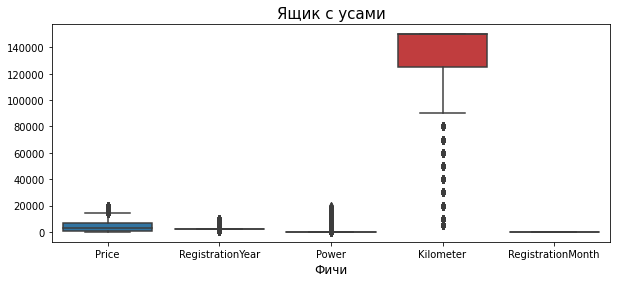

In [ ]:
plt.figure(figsize=(10,4))
sns.boxplot(data=data)
plt.title('Ящик с усами', fontsize=15)
plt.xlabel('Фичи', fontsize=12)

<AxesSubplot:>

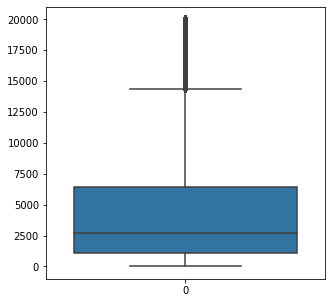

In [ ]:
plt.figure(figsize=(5,5))
sns.boxplot(data=data['Price'])

In [ ]:
len(data['Price'].loc[data['Price'] == 0])

10772

Почти 11 тысяч строк с нулвой ценой.

In [ ]:
len(data['Price'].loc[data['Price'] == 0])/ len(data) *100

3.0397692800442475

Всего 3% данных с нулевым целевым признаком. Уберём эти строки.

In [ ]:
data = data.drop(data[data.Price <= 0].index)

In [ ]:
len(data['Price'].loc[data['Price'] == 0])

0

In [ ]:
data['Power'].value_counts().sort_index()

0        36360
1           27
2            9
3            9
4           30
         ...  
17932        1
19208        1
19211        1
19312        1
20000        1
Name: Power, Length: 701, dtype: int64

In [ ]:
len(data['Power'].loc[data['Power'] == 0])/ len(data) *100

10.58216457070347

Думаю можно удалить эти 10% 

In [ ]:
data = data.drop(data[data.Power <= 0].index)

In [ ]:
data['DateCrawled'].min()

'2016-03-05 14:06:22'

In [ ]:
data['RegistrationYear'].sort_values().unique()#.value_counts().sort_index()

array([1000, 1234, 1400, 1500, 1600, 1800, 1910, 1923, 1927, 1928, 1929,
       1930, 1931, 1932, 1933, 1935, 1936, 1937, 1938, 1940, 1941, 1942,
       1943, 1944, 1945, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954,
       1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965,
       1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976,
       1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987,
       1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998,
       1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,
       2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2800,
       2900, 3000, 4000, 4500, 4800, 5000, 5911, 6000, 6500, 8000, 8200,
       9999])

In [ ]:
data = data.drop(data[(data.RegistrationYear < 1910)&(data.RegistrationYear > 2016)].index)

In [ ]:
data['RegistrationYear'].sort_values().unique()

array([1000, 1234, 1400, 1500, 1600, 1800, 1910, 1923, 1927, 1928, 1929,
       1930, 1931, 1932, 1933, 1935, 1936, 1937, 1938, 1940, 1941, 1942,
       1943, 1944, 1945, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954,
       1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965,
       1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976,
       1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987,
       1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998,
       1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,
       2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2800,
       2900, 3000, 4000, 4500, 4800, 5000, 5911, 6000, 6500, 8000, 8200,
       9999])

### дубликаты

In [ ]:
Dup_Rows = data[data.duplicated()]
print("\n\nПовторяющиеся строки : \n {}".format(Dup_Rows))



Повторяющиеся строки : 
                 DateCrawled  Price VehicleType  RegistrationYear Gearbox  \
116439  2016-03-22 21:58:18   1500       sedan              2001  manual   
149164  2016-03-07 12:00:46  10000       wagon              2013  manual   
169498  2016-03-15 02:02:43   1600       coupe              1995  manual   
171088  2016-03-08 18:42:48   1799       coupe              1999    auto   
179521  2016-03-19 13:36:23   8750       small              2012  manual   
209732  2016-04-02 10:43:57   1990       coupe              2000  manual   
216300  2016-03-21 19:46:53  15299       sedan              2004    auto   
231258  2016-03-28 00:56:10   1000       small              2002  manual   
232438  2016-03-22 01:51:32   2000       sedan              1999  manual   
254900  2016-03-13 17:06:23   9000       coupe              2005    auto   
255297  2016-03-19 20:54:35   1450       small              2001  manual   
258109  2016-04-03 09:01:15   4699       coupe              2

In [ ]:
data.drop_duplicates(inplace = True)

In [ ]:
Dup_Rows = data[data.duplicated()]
print("\n\nПовторяющиеся строки : \n {}".format(Dup_Rows))



Повторяющиеся строки : 
 Empty DataFrame
Columns: [DateCrawled, Price, VehicleType, RegistrationYear, Gearbox, Power, Model, Kilometer, RegistrationMonth, FuelType, Brand, NotRepaired, DateCreated]
Index: []


In [ ]:
data['Model'].sort_values().unique()

array(['100', '145', '147', '156', '159', '1_reihe', '1er', '200',
       '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe',
       '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900',
       '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8',
       'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea',
       'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo',
       'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora',
       'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse',
       'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma',
       'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee',
       'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo',
       'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma',
       'crossfire', 'cuore', 'cx_reihe', 'defender', 'delta', 'discovery',
       'doblo', 'ducato', 'duster', 'e_klasse', 'elefantino', 'eos',
       'escort', 'espac

In [ ]:
len(data['Model'].loc[data['Model'] == 'range_rover'])

69

In [ ]:
len(data['Model'].loc[data['Model'] == 'rangerover']) 

3

In [ ]:
data.loc[data['Model'] == 'rangerover','Model'] = 'range_rover'

In [ ]:
len(data['Model'].loc[data['Model'] == 'rangerover']) 

0

In [ ]:
data.drop(['DateCrawled','DateCreated'], axis=1, inplace=True)

### Кодирование данных

In [ ]:
data = pd.get_dummies(data, drop_first=True)

In [ ]:
data

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,...,Brand_skoda,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_yes
1,18300,2011,190,125000,5,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,9800,2004,163,125000,8,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1500,2001,75,150000,6,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4,3600,2008,69,90000,7,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
5,650,1995,102,150000,10,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354361,5250,2016,150,150000,12,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
354362,3200,2004,225,150000,5,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
354366,1199,2000,101,125000,3,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
354367,9200,1996,102,150000,3,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


## Обучение моделей

### Простая линейная регрессия.

Разделим на выборки.

In [ ]:
target = data['Price']
features = data.drop(['Price'] , axis=1)

In [ ]:
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.25, random_state=12345) 

### Масштабирование

In [ ]:
numeric = ['Power','Kilometer']

In [ ]:
scaler = StandardScaler()
scaler.fit(features_train[numeric])

StandardScaler()

In [ ]:
pd.options.mode.chained_assignment = None
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric]) 

In [ ]:
def linear(feature,target,test_target):
    model = LinearRegression()
    model.fit(feature, target)
    
    start = time.time()
    predict = model.predict(features_valid)
    end = time.time()
    print('Время предсказания',end - start)
    
    RMSE = mean_squared_error(target_valid, predict)**0.5
    print('RMSE',RMSE)
    #return[model,predict]

In [ ]:
%%time
linear(features_train,target_train,target_valid)

Время предсказания 0.19575715065002441
RMSE 3184.0839460139027
CPU times: user 16.6 s, sys: 5.89 s, total: 22.5 s
Wall time: 22.5 s


RMSE 3206 - это нам не подходит. Едем дальше.

RMSE 3184 - после скалирования

### XGBoost

In [ ]:
def XGBRegressor(feature,target,test_target):
    model = xgb.XGBRegressor(n_estimators=10,max_depth=7)
    model.fit(feature, target)
    start = time.time()
    predict = model.predict(features_valid)
    end = time.time()
    print('Время предсказания',end - start)
    RMSE = mean_squared_error(target_valid, predict)**0.5
    print('RMSE',RMSE)

In [ ]:
%%time
XGBRegressor(features_train,target_train,target_valid)

Время предсказания 0.8863637447357178
RMSE 1845.5444837614139
CPU times: user 58.3 s, sys: 759 ms, total: 59.1 s
Wall time: 59.1 s


RMSE 1899.0097913587113 - Что выполняет условия задачи, а так же на обучение затрачено меньше минуты.

RMSE 1845.5444837614139 - после скалирования, Время предсказания 0.88

### LightGBM

In [ ]:
def LGBMRegressor(feature,target,test_target):
    model = lgb.LGBMRegressor()
    clf = GridSearchCV(model, {'max_depth': [1, 10, 1],
                               'n_estimators': [1, 50, 5]}, verbose=1,
                                scoring='neg_root_mean_squared_error')
                                                                    
    clf.fit(feature, target)
    predict = clf.predict(features_valid)
    
    RMSE = mean_squared_error(target_valid, predict)**0.5
    print('RMSE',RMSE)
    print(clf.best_score_)
    print(clf.best_params_)

In [ ]:
%%time
LGBMRegressor(features_train,target_train,target_valid)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
RMSE 1856.8793773661555
0.8294714914262407
{'max_depth': 10, 'n_estimators': 50}
CPU times: user 23min 51s, sys: 29.8 s, total: 24min 21s
Wall time: 24min 30s


C аналогичными настройками LightGBM выдает RMSE 2678.299401101266.

{'max_depth': 10, 'n_estimators': 50} - лучшие параметры. но это не предел

In [ ]:
def LGBMRegressor_2(feature,target,test_target):
    model = lgb.LGBMRegressor()  
    model.fit(feature, target)
    start = time.time()
    predict = model.predict(features_valid)
    end = time.time()
    print('Время предсказания',end - start)
    
    RMSE = mean_squared_error(target_valid, predict)**0.5
    print('RMSE',RMSE)

In [ ]:
%%time
LGBMRegressor_2(features_train,target_train,target_valid)

Время предсказания 0.9983413219451904
RMSE 1713.8153336215935
CPU times: user 25.2 s, sys: 648 ms, total: 25.8 s
Wall time: 26.1 s


C дефолтными настрйоками GridSearchCV результат RMSE 1766.5249646852487

RMSE 1713 - после скалирования, Время предсказания 0.99

## Анализ моделей

<table class="iksweb">
	<tbody>
		<tr>
			<td>Модель</td>
			<td>Время предсказания</td>
			<td>Время обучения</td>
            <td>RMSE</td>
		</tr>
		<tr>
			<td>LinearRegression</td>
			<td>0.19</td>
			<td>22.5</td>
            <td>3184</td>
		</tr>
        <tr>
			<td>XGBRegressor</td>
			<td>0.88</td>
			<td>59.1</td>
            <td>1845</td>
		</tr>
        <tr>
			<td>LGBMRegressor</td>
			<td>0.99</td>
			<td>26.1</td>
            <td>1713</td>
		</tr>

## Вывод

Скалирование положительно сказалось на всех нужных параметрах. Лучшая модель LGBMRegressor время предсказания меньше 1 сек, обучение 26,1 сек, самый лучший результат по RMSE